# Chinook Database

We'll be using an SQLite database file for an imaginary company "Chinook" that sells digital music.

The database [chinook.db](https://github.com/lerocha/chinook-database) contains tables for invoices, customers, employees, artists, tracks, and more

In [3]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

In [4]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


# Which of the 4 albums should Chinook add to the store?

The Chinook record store just signed a deal with a new record label that focuses on artists in the USA. We have been tasked to select 3 of the 4 albums listed below.

|Artist Name| Genre |
| ----------|-------|
| Regal     | Hip hop|
| Red Tone  | Punk|
| Metro and the Girls | Pop|
| Slim Jim Bites | Blues |


We have the artists' names and genre of music they produce. To answer the question above, we should look at the most popular genres in the USA. To do this, we'll find the total tracks sold by each genre in the USA and the % of total tracks sold. We can retrieve this information from the `customer`, `invoice`, `invoice_line`, `track`, and `genre` tables by using multiple `Joining` keywords

In [3]:
%%sql

WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;

Done.


genre,tracks_sold,percentage_sold
Rock,561,0.5337773549000951
Alternative & Punk,130,0.12369172216936251
Metal,124,0.11798287345385347
R&B/Soul,53,0.05042816365366318
Blues,36,0.03425309229305423
Alternative,35,0.03330161750713606
Latin,22,0.02093244529019981
Pop,22,0.02093244529019981
Hip Hop/Rap,20,0.019029495718363463
Jazz,14,0.013320647002854425



Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

# Exploring Customer Purchases Based on Employees

Whenever a customer first makes a purchase, they are assigned to a sales support representative. We were tasked to analyze employee performance based on the number of and total sales each one has. We can retrieve this information through the `employee`, `customer`, `invoice`, and `invoice_line` tables.

,employee_name,hire_date,country,num_transactions,dollar_sales,pct_sales,emp_duration_days
0,Jane Peacock,2017-04-01 00:00:00,Canada,1749,18246.69,38.41,1369
1,Margaret Park,2017-05-03 00:00:00,Canada,1600,15923.16,33.52,1336
2,Steve Johnson,2017-10-17 00:00:00,Canada,1408,13333.32,28.07,1160


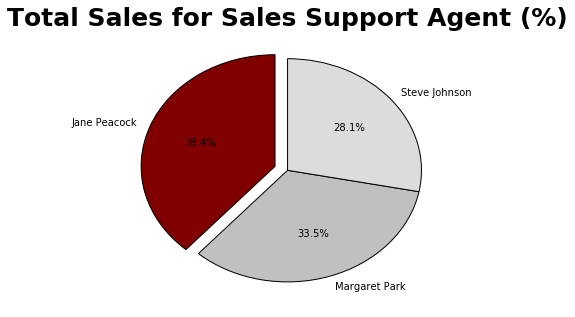

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

query = """ 
WITH 
sales_agents AS (SELECT *
                   FROM employee
                    WHERE title = 'Sales Support Agent'),
employee_info AS (SELECT * 
                  FROM sales_agents sa
                  LEFT JOIN customer c ON sa.employee_id = c.support_rep_id
                  INNER JOIN invoice i ON c.customer_id = i.customer_id
                  INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
                 INNER JOIN track t ON il.track_id = t.track_id 
                 INNER JOIN (SELECT *, name genre_name 
                                             FROM genre) g ON t.genre_id = g.genre_id )

SELECT 
 first_name || ' ' || last_name employee_name,
 hire_date,
 country,
 COUNT (*) num_transactions,
 ROUND(SUM(total), 2) dollar_sales,
 ROUND(SUM(total) / (SELECT SUM(total) FROM employee_info)*100, 2) pct_sales,
 (strftime('%s',MAX(invoice_date)) - strftime('%s',hire_date))/60/60/24 emp_duration_days
FROM employee_info
GROUP BY employee_id;
"""
conn = sqlite3.connect("chinook.db")
df_e_info = pd.read_sql_query(query, conn)

fig, ax = plt.subplots(figsize=(6,5))
colors = ['maroon','silver','gainsboro']

ax.pie(x=df_e_info['pct_sales'], labels=df_e_info['employee_name'], colors=colors,
       explode=(0.1,0,0), autopct="%1.1f%%", startangle=90)
plt.title("Total Sales for Sales Support Agent (%)", fontdict={'fontsize':25,'fontweight':'bold'})


df_e_info

So we can see that Jane's sales are ~16% higher than Steve's sales, and that she's been employed for about 10% longer. In the end, Jane is outperforming Steve by a modest margin of about 5%.

Furthermore, Jane's sales are about 8.5% higher than Margaret's, even though she's only been here 2.5% longer. She's outperforming Margaret by about 6%.

Margaret's sales are about 12% higher than Steve's, but she has been employeed for 13% longer. This makes Margaret the worst performer by a negligible amount (1%).

Ultimately, we see that the differences in total sales are most likely attributed to the duration of employment rather than a single rep performing better or worse than the others, although Jane does seem to perform slightly better.

# Analyzing Customers From Different Countries

Now we collect data on purchases for customers from different countries, including total number and \% of customers, total value and \% of sales, average value of sales per customer, average order value. Because in our database there are some countries with only one customer, we'll collect those countries into an "Other" group.

,countries,customers,total_sales,avg_sales_per_cust,avg_order_value
0,USA,13,1040.49,10,7.94
1,Canada,8,535.59,9,7.05
2,Brazil,5,427.68,12,7.01
3,France,5,389.07,10,7.78
4,Germany,4,334.62,10,8.16
5,Czech Republic,2,273.24,15,9.11
6,United Kingdom,3,245.52,9,8.77
7,Portugal,2,185.13,14,6.38
8,India,2,183.15,10,8.72
9,Other,15,1094.94,9,7.45


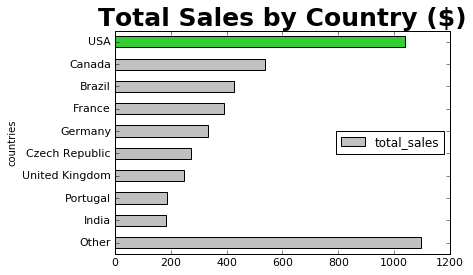

In [52]:
customer_country_query = """
WITH nc AS 
   (SELECT country,
       COUNT (c.customer_id) num_customer
        FROM customer c
        GROUP BY 1),
    ci AS
      (SELECT * 
       FROM customer c
       INNER JOIN invoice i ON c.customer_id = i.customer_id),
    i_by_country AS
      (SELECT CASE 
                WHEN nc.num_customer = 1 then 'Other'
                ELSE nc.country
                END countries,
                COUNT(DISTINCT(customer_id)) customers,
                ROUND(SUM(ci.total),2) total_sales,
                COUNT(ci.invoice_id)/ COUNT(DISTINCT(customer_id)) avg_sales_per_cust,
                ROUND(AVG(ci.total), 2) avg_order_value
        FROM nc
        INNER JOIN ci ON ci.country = nc.country
        GROUP BY countries
        ORDER BY total_sales DESC)
SELECT countries,
       customers,
       total_sales,
       avg_sales_per_cust,
       avg_order_value
FROM (SELECT i_by_country.*,
             CASE
                 WHEN i_by_country.countries = 'Other' THEN 1
                 ELSE 0
             END sort
    FROM i_by_country)
ORDER BY sort ASC;
"""
customers_by_countries = pd.read_sql_query(customer_country_query, conn)

## Flipped the table to make USA appear first in the graph
cc = customers_by_countries[::-1]



cc.plot.barh(x= 'countries', y='total_sales', 
        color=['silver','silver','silver','silver','silver',
              'silver','silver','silver','silver','limegreen'])
plt.title("Total Sales by Country ($)", fontdict={'fontsize':25, 'fontweight':'bold'})
plt.tick_params(labelsize=11)

customers_by_countries



Three countries stand out in particular:

- Czech Republic
- Portugal
- India

There may be opportunities to expand the customer base in each of these countries because the average sales per customer is high. However, since the overall amount of data is very small, exercise caution when investing in advertising for these markets.

# Do people buy whole albums or single tracks more often?

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.
The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In this task, we have two edge cases to consider:

Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.
In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

,purchase_type,invoice_count,pct
0,Album,111,18.08
1,Individual Tracks,503,81.92


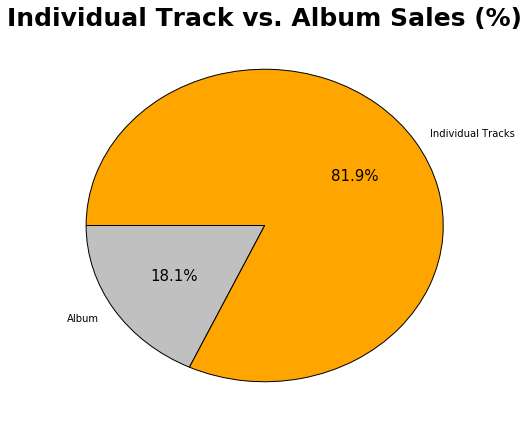

In [2]:
purchase_type_query = """
WITH number_of_tracks AS
 
     (SELECT t.album_id,
             COUNT(t.track_id) tracks_per_album
             FROM track t
             GROUP BY album_id),

tracks_per_invoice AS
     (SELECT il.invoice_id,
             t.album_id,
      COUNT (il.track_id) track_count
      FROM track t
      INNER JOIN invoice_line il ON il.track_id = t.track_id
      GROUP BY 1,2
     ),
ind_vs_album AS 
     (SELECT *,
      CASE 
         WHEN tpi.track_count != nbt.tracks_per_album THEN 'Individual Tracks'
         WHEN tpi.track_count = 1 THEN 'Individual Tracks'
         ELSE 'Album'
      END 'purchase_type'
      FROM tracks_per_invoice tpi
      INNER JOIN number_of_tracks nbt ON tpi.album_id = nbt.album_id
     )

SELECT purchase_type,
       COUNT(DISTINCT(invoice_id)) invoice_count,
       ROUND(CAST(COUNT(DISTINCT(invoice_id)) AS FLOAT) / (SELECT COUNT(DISTINCT(invoice_id)) 
                                                           FROM ind_vs_album),4) * 100 pct
FROM ind_vs_album
GROUP BY purchase_type;

"""

purchase_type = pd.read_sql_query(purchase_type_query, conn)

fig, ax = plt.subplots(1,1, figsize=(8,7))

ax.pie(x=purchase_type['pct'], labels=purchase_type['purchase_type'], colors=['silver','orange'], 
       autopct='%1.1f%%', startangle=180, textprops={'fontsize':15})
plt.title("Individual Track vs. Album Sales (%)", fontdict={'fontsize':25,'fontweight':'bold'})

purchase_type
    

Customers tend to buy individual tracks 4 times more often than the whole albums. This means that the new strategy in consideration (purchasing only the most popular tracks from each album from record companies instead of purchasing the whole albums) will definitely help to maximize the overall revenue.

# The most listened artists

Next, we're going to find out which artists are used in the most playlists. This information can give us valuable insights on further purchasing strategies of the Chinook store. The tables to be used are `artist`, `album`, `track`, and `playlist_track`.

In [10]:
%%sql
SELECT ar.name artist_name,
       COUNT(DISTINCT(pt.playlist_id)) num_playlists
    FROM artist ar
    INNER JOIN album al ON ar.artist_id = al.artist_id
    INNER JOIN track t ON al.album_id = t.album_id
    INNER JOIN playlist_track pt ON t.track_id = pt.track_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;

Done.


artist_name,num_playlists
Eugene Ormandy,7
Academy of St. Martin in the Fields & Sir Neville Marriner,6
Berliner Philharmoniker & Herbert Von Karajan,6
English Concert & Trevor Pinnock,6
The King's Singers,6
"Academy of St. Martin in the Fields, Sir Neville Marriner & Thurston Dart",5
Adrian Leaper & Doreen de Feis,5
Alberto Turco & Nova Schola Gregoriana,5
Antal Doráti & London Symphony Orchestra,5
Barry Wordsworth & BBC Concert Orchestra,5


Based on our findings, we see that Eugene Ormandy was the most common artist amongst the playlists, being in 7 different playlists. There were 4 other artists that were in 6 playlists and many other artists that were in 5 playlists or fewer.

# Purchased vs Not Purchased Tracks

The Chinook store is trying to see what songs are purchased and not purchased. First, they want to see how much of their inventory is actually being sold. To do this, we must find the number of tracks sold and not sold and the percentage of each. We will compare all the tracks in the track table with the ``invoice_line`` table and if it's not in the ``invoice_line`` table then it was not purchased.

,Status,num_tracks,pct
0,Not purchased,1697,48.4
1,Purchased,1806,51.6


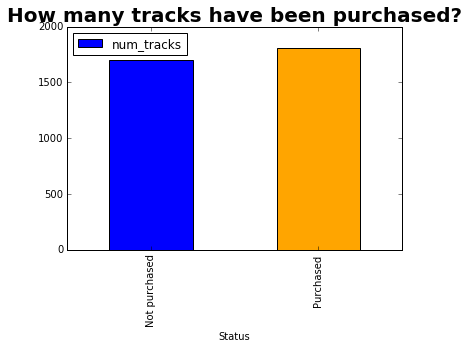

In [23]:
purchase_query = """
SELECT CASE 
   WHEN EXISTS(SELECT *
              FROM invoice_line il
              WHERE t.track_id = il.track_id)
         THEN 'Purchased'
         ELSE 'Not purchased'
    END AS 'Status',
    COUNT (t.track_id)  num_tracks,
    ROUND(CAST(COUNT(*) AS FLOAT) / (SELECT COUNT(*) FROM track),3) * 100 pct 
FROM track t
GROUP BY Status;

"""

purchased = pd.read_sql_query(purchase_query, conn)
color = ['blue', 'orange']
purchased.plot.bar(x='Status', y='num_tracks', color=color)


plt.title("How many tracks have been purchased?", fontdict={'fontsize':20, 'fontweight':'bold'})

purchased


Based on our findings, we can see that 1806 (51.56%) out of 3503 total tracks were purchased. So, this means 48.44% of the tracks in the store were not purchased. If Chinook is having a problem with their sales, they may want to look into adding more popular artists and removing the artists that aren't selling well or at all.Possible solutions here may include a new advertising campaign (especialy in the USA, as the biggest segment of market), sales promotion, additional training and motivation of the sales support agents.

# Is the range of tracks in the store reflective of their sales popularity?

The Chinook store is looking to diversify their store's selection. They want to find out if having more tracks correlates with sales popularity. To do this, we will find the total number of tracks in each genre and the total sales for each. We can retrieve this information from the track, genre, invoice, and invoice_line tables.

In [20]:
t_variety_vs_sales_query = """
WITH total_tracks AS
   (
   SELECT g.name genre_name,
         COUNT (t.track_id) total_tracks
   FROM track t
   INNER JOIN genre g ON g.genre_id = t.genre_id
   GROUP BY 1),
total_sales AS
   (SELECT g.name genre_name,
    ROUND(SUM(i.total),2) total_sales
    FROM track t
    INNER JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    GROUP BY 1)
SELECT ts.*,
       tt.total_tracks
      FROM total_sales ts
        INNER JOIN total_tracks tt ON tt.genre_name = ts.genre_name
"""   

,genre_name,total_sales,total_tracks
0,Alternative,1095.93,40
1,Alternative & Punk,4841.10,332
2,Blues,1379.07,81
3,Classical,361.35,74
4,Drama,5.94,64
5,Easy Listening,951.39,24
6,Electronica/Dance,614.79,30
7,Heavy Metal,70.29,28
8,Hip Hop/Rap,463.32,35
9,Jazz,1302.84,130


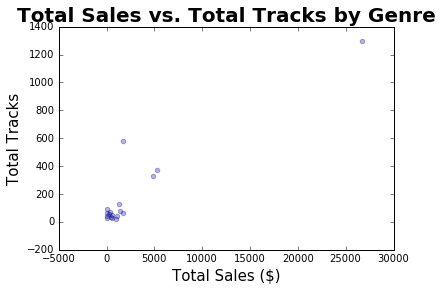

In [26]:
data = pd.read_sql_query(t_variety_vs_sales_query, conn)

plt.scatter(data['total_sales'], data['total_tracks'], alpha=0.3)
plt.title("Total Sales vs. Total Tracks by Genre", fontdict={'fontsize':20,'fontweight':'bold'})
plt.xlabel("Total Sales ($)", fontsize=15)
plt.ylabel("Total Tracks", fontsize=15)



data

In [25]:
data.corr()

,total_sales,total_tracks
total_sales,1.000000,0.929652
total_tracks,0.929652,1.000000


Based on our findings above, we can see that there is a strong positive correlation with total tracks and total sales for each genre, with a correlation of .929.

From this, we can recommend Chinook to find the most popular tracks in each genre and diversify their store selection.

# Popularity of Protected vs Non-Protected Media Types

f a track has a protected media type, it means that it has some associated rules for using its content. It can be encrypted using some form of digital rights management encryption. To play such a file, playback must occur inside the protected media path. In addition, the user might have to acquire rights to the content.

Let's start by looking at the unique values of media types and whether there are any protected types among them.

In [99]:
protected_query = """

WITH protected_type AS
     (SELECT *
             FROM media_type
             WHERE name LIKE '%Protected%'),
classified_invoice AS
     (SELECT i.invoice_id,
             t.media_type_id,
             i.total,
             CASE
                 WHEN t.media_type_id = pt.media_type_id
                 THEN 'Protected'
                 ELSE 'Non-Protected'
             END AS 'media_type'
             FROM invoice i
             INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
             INNER JOIN track t ON il.track_id = t.track_id
             LEFT JOIN protected_type pt ON t.media_type_id = pt.media_type_id)
SELECT media_type,
       COUNT(invoice_id) num_invoice,
       ROUND(SUM(total), 3) total_sales,
       ROUND(CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(invoice_id) FROM classified_invoice),3) * 100 pct
    FROM classified_invoice
    GROUP BY 1;
"""

,media_type,num_invoice,total_sales,pct
0,Non-Protected,4315,43362.00,90.7
1,Protected,442,4141.17,9.3


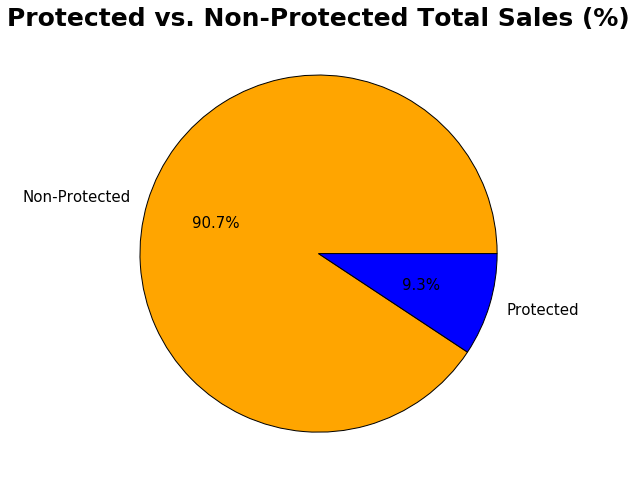

In [100]:
protected = pd.read_sql_query(protected_query, conn)

fig, ax = plt.subplots(figsize=(8,8))

colors = ['orange','blue']

ax.pie(x=protected['pct'], labels=protected['media_type'], colors=colors, autopct="%1.1f%%", textprops={'fontsize':15})
plt.title("Protected vs. Non-Protected Total Sales (%)", fontdict={'fontsize':25,'fontweight':'bold'})

protected

In a nutshell, the tracks of protected media types are much less popular than those of non-protected, both in terms of the store assortment and, especially, in terms of sales. It can be easily explained by a cumbersome way of their using, which is not really justified when it comes to buying media products for entertainment. Hence, as a future strategy, it is not recommended to the store to purchase such tracks from record companies.

%%sql
WITH protected_type AS
     (SELECT *
             FROM media_type
             WHERE name LIKE '%Protected%'),
q2 AS (SELECT 
             i.invoice_id,
             t.media_type_id,
             i.total,
             CASE
                 WHEN t.media_type_id = pt.media_type_id
                 THEN 'Protected'
                 ELSE 'Non-Protected'
             END AS 'media_type'
             FROM invoice i
             INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
             INNER JOIN track t ON il.track_id = t.track_id
             LEFT JOIN protected_type pt ON t.media_type_id = pt.media_type_id)
SELECT 
       invoice_id,
       media_type,
       COUNT(invoice_id),
       (SELECT COUNT (invoice_id) FROM q2)
    FROM q2
GROUP BY media_type;


# Conclusion


In this project, we used a modified version of the Chinook database to answer general business questions. The questions we addressed are as follows:

Given 4 new albums, which albums should Chinook add to their store?
1. Who had the top sales performance amongst the sales agents?
2. Which countries had the most sales?
3. Chinook is looking to change their purchasing strategy, so are individual track sales or album sales more popular?
4. Which artist is used in the most playlists?
5. How many tracks have been purchased vs not purchased?
6. Is the range of tracks in the store reflective of their sales popularity?
7. Do protected vs. non-protected media types have an effect on popularity?

# Main Results

1. Given the 4 albums, Chinook should add Red Tone's (Punk), Metero and the Girls' (Blues), and Slim Jim Bites' albums (Pop). Based on genres, punk ranked 2nd with 12.37% of sales, blues ranked 5th with 3.43%, pop ranked 8th with 2.09%.

2. Out of the 3 sales support agents, Jane Peacock had the top sales performance with 38% of total sales, 1749 transactions, $18,246.69 in total sales, and an average sale of $10.43.
USA had the most sales with 13 customers and $1040.49 in total sales, 10 sales per customer, and an average order value of $7.94.

3. With the 2 types of purchases, people bought individual tracks more often than whole albums. Individual track sales held 81.92% of total sales with 503 unique invoices.
Eugene Ormandy was the most common artist amongst the playlists, being in 7 different playlists.
1806 (51.56%) out of 3503 total tracks were purchased.

4. There is a strong positive correlation with range of tracks and total sales for each genre, with a correlation of .929.

5. Non-protected tracks took up 90.7% of total sales. This does not imply causation, but simply a positive correlation